# **<span style="color:cyan">The Next Study?</span>**

## Config

In [1]:
import sys
import os
import joblib
import matplotlib.pyplot as plt

# racine du projet
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

print(f"Racine ajoutée : {project_root}")

Racine ajoutée : c:\Users\aurel\Desktop\BUT\Data Mining\Project_RecSys


In [2]:
from src.data_loading import load_articles, load_profile_keywords
from src.text_vectorizer import fit_vectorizer
from src.profile_builder import build_profile_text, profile_to_vector
from src.recommender import (
    recommend_for_profile,
    recommend_hot_articles,
    recommend_similar_to_article,
    update_profile_with_likes,
)
from src.get_trends import get_hot_terms

In [3]:
plt.style.use('dark_background')

## EDA

In [4]:
# Chargement des data
print(">> Loading data...")
articles_df = load_articles()
profile_kw_df = load_profile_keywords()

print(f"  - {len(articles_df)} articles loaded")
articles_df[["id", "title", "field", "year"]].head()

>> Loading data...
  - 4368 articles loaded


,id,title,field,year
0,W3038378976,"Measurement of <mml:math xmlns:mml=""http://www...",Particle physics,2020
1,W2168495796,From Natural Variation to Optimal Policy? The ...,Game theory,2013
2,W2897927724,Material Design for Photocatalytic Water Split...,Solar energy,2018
3,W2921474111,Gossypium barbadense and Gossypium hirsutum ge...,Genomics,2019
4,W2732194751,Mobility as a Service: A Critical Review of De...,Operations research,2017


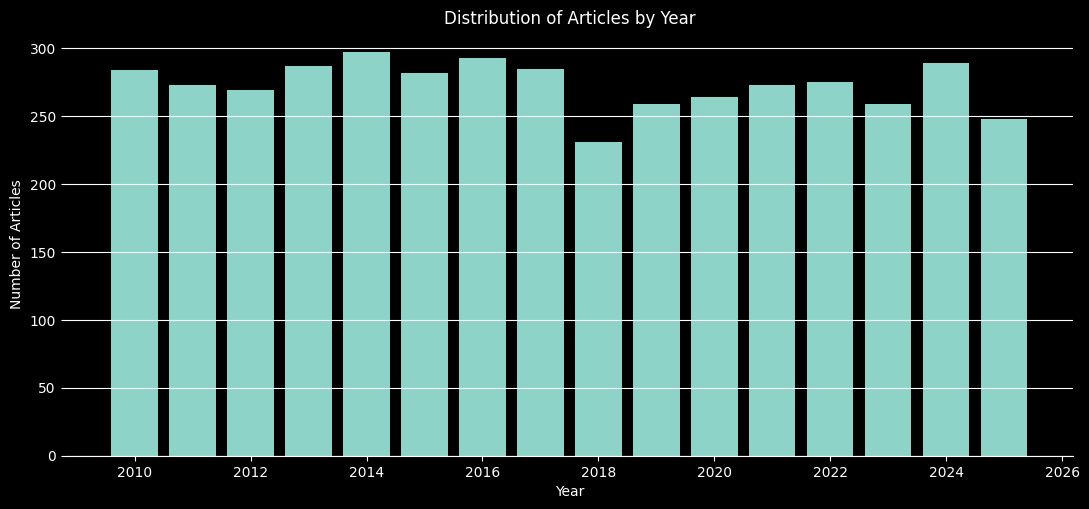

In [5]:
plt.figure(figsize=(13, 5.5))
index = articles_df['year'].value_counts().sort_index().index
vals = articles_df['year'].value_counts().sort_index().values
plt.bar(index, vals) # type: ignore
plt.title('Distribution of Articles by Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
for s in ['top', 'right', 'left']:
    plt.gca().spines[s].set_visible(False)
plt.grid(axis='y')
plt.show()

In [6]:
# nb of thematics
print(f"Number of unique article fields: {articles_df['field'].nunique()}")

Number of unique article fields: 141


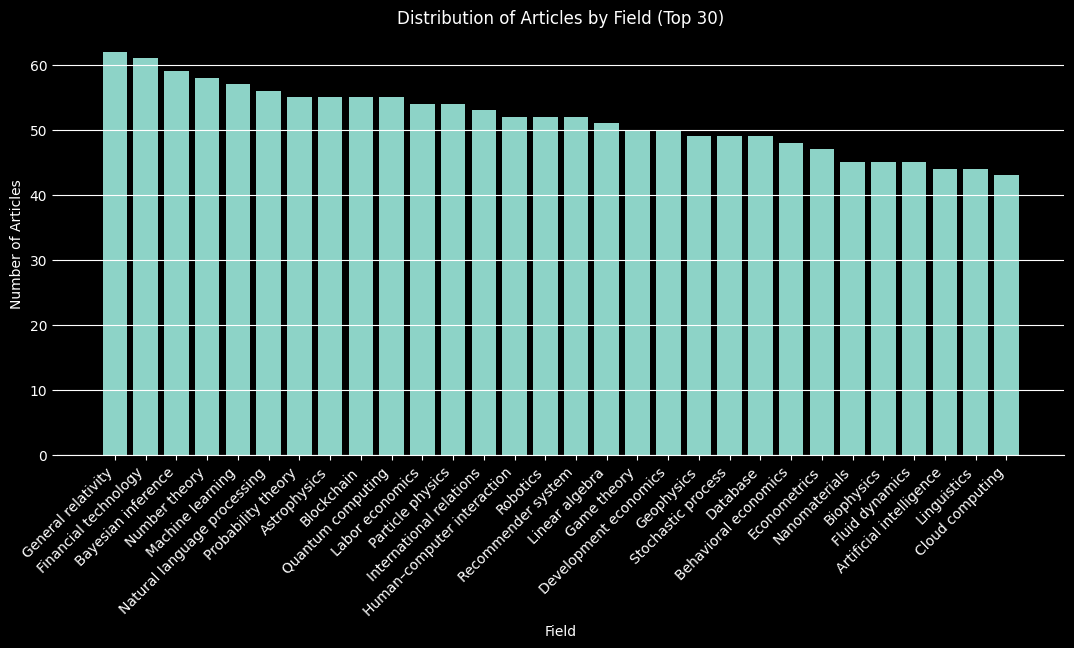

In [7]:
plt.figure(figsize=(13, 5.5))
plt.bar(articles_df['field'].value_counts().index[:30], articles_df['field'].value_counts().values[:30]) # type: ignore
plt.title('Distribution of Articles by Field (Top 30)')
plt.xlabel('Field')
plt.ylabel('Number of Articles')
for s in ['top', 'right', 'left']:
    plt.gca().spines[s].set_visible(False)
plt.grid(axis='y')
plt.xticks(rotation=45, ha='right')
plt.show()

## Recommendation System

**1. Vectorisation (TF-IDF) :**

Dans cette première étape, nous construisons la "sémantique" du système.

Nous transformons donc le contenu textuel brut de nos articles (titre, résumé et domaine) en vecteurs mathématiques exploitables. L'utilisation du **TF-IDF** nous permet de pondérer l'importance des mots : un mot rare qui apparaît souvent dans un article aura un poids fort (car il est discriminant).

On obtient une matrice massive `(4368, 408857)`, signifiant que notre modèle connaît désormais 408 857 termes uniques pour caractériser nos articles.

In [8]:
# 1) TF-IDF sur le texte des articles
print(">> Fitting TF-IDF vectorizer...")
vectorizer, X_tfidf = fit_vectorizer(articles_df["text"])
print(f"  - Matrix shape: {X_tfidf.shape}\n")

>> Fitting TF-IDF vectorizer...
  - Matrix shape: (4368, 408857)



### Recommandation d'articles basées sur le profil utilisateur

**2. Simulation du Profil (Persona)**

Pour tester notre système, nous définissons un **profil utilisateur cible** (ou "Persona") avec des préférences précises (ex: *Machine Learning*).

L'idée n'est pas de chercher ces mots bêtement. La fonction `build_profile_text` va plus loin : elle crée une **empreinte textuelle complète** des intérêts de l'utilisateur. Elle génère un "super-article" virtuel riche en vocabulaire technique. 

Ensuite, l'étape de **vectorisation** (`profile_to_vector`) traduit ce texte en une série de chiffres (un vecteur). C'est ce format qui permet au program de **comparer** ce profil avec les articles pour trouver les meilleures correspondances.

Ce texte sert alors de référence pour "aimanter" les articles les plus pertinents dans notre espace vectoriel.

In [9]:
# 2) Simuler des préférences utilisateur
prefs = {
    "field": ["machine_learning", "recommender_systems"],
    "type": ["empirical"],
    "impact": ["high_impact"],
}

print(">> Building user profile from prefs:", prefs)
profile_text = build_profile_text(prefs, profile_kw_df)
print("  - Profile text:\n", profile_text[:300], "...\n")

>> Building user profile from prefs: {'field': ['machine_learning', 'recommender_systems'], 'type': ['empirical'], 'impact': ['high_impact']}
  - Profile text:
 machine learning supervised learning unsupervised learning classification regression clustering data mining recommender systems collaborative filtering content based recommendation ranking user preference personalization empirical study real world data estimation experimental evaluation numerical re ...



In [10]:
v_profile = profile_to_vector(profile_text, vectorizer)
print(f"  - Profile vector: {v_profile}\n")

  - Profile vector: <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 66 stored elements and shape (1, 408857)>
  Coords	Values
  (0, 29638)	0.059729923170580415
  (0, 41944)	0.0438017601147972
  (0, 42943)	0.14886100544546038
  (0, 65922)	0.09022885993752558
  (0, 66053)	0.17711918302565624
  (0, 67609)	0.10956292709586912
  (0, 67627)	0.16299009423555832
  (0, 69259)	0.10712090347262451
  (0, 69273)	0.13349614640550217
  (0, 82375)	0.09452773507422907
  (0, 82387)	0.14059601833389343
  (0, 93394)	0.09274150052048957
  (0, 93837)	0.17711918302565624
  (0, 94147)	0.11320537450101764
  (0, 96602)	0.08505828148091427
  (0, 96636)	0.09618888634051469
  (0, 126830)	0.08334972449544505
  (0, 126919)	0.15472510712399137
  (0, 134861)	0.09187241372871445
  (0, 136023)	0.08225301194803454
  (0, 140738)	0.07821556149497072
  (0, 140779)	0.15472510712399137
  (0, 149113)	0.11820194243222858
  (0, 149125)	0.17711918302565624
  (0, 181692)	0.07120958179306548
  :	:
  (0, 303643)	0.1273

**3. Calcul de Similarité et Recommandation**

Maintenant que nous avons traduit le profil utilisateur en chiffres (le vecteur `v_profile`), nous pouvons le comparer à notre base de données.

La fonction `recommend_for_profile` calcule la **similarité cosinus** entre le vecteur de l'utilisateur et celui de chaque article. En termes simples, elle mesure la distance mathématique entre les deux : plus ils sont proches, plus l'article correspond aux goûts de l'utilisateur.

Le système trie ensuite ces résultats pour ne garder que les **5 articles les plus pertinents** (`top_k=5`).

In [11]:
# 3) Recommandations basées sur le profil
print(">> Recommending articles for this profile...")
recs_profile = recommend_for_profile(
    v_profile, X_tfidf, articles_df, top_k=5
)
print("Top-5 for profile:")
recs_profile[["id", "title", "field", "year"]]

>> Recommending articles for this profile...
Top-5 for profile:


,id,title,field,year
3894,W2024095636,"Survey on Collaborative Filtering, Content-bas...",Recommender system,2015
2888,W2743289629,Bridging Collaborative Filtering and Semi-Supe...,Recommender system,2017
1676,W3135939397,A Decade Survey of Transfer Learning (2010–2020),Robotics,2020
3028,W4390490824,Causal Inference in Recommender Systems: A Sur...,Recommender system,2024
3337,W2087692915,Exploiting geographical influence for collabor...,Recommender system,2011


### Recommendation d'articles basées sur les articles likés

**4. Boucle de Feedback (Apprentissage Actif)**

Un système de recommandation moderne ne doit pas être statique : il doit s'adapter aux actions de l'utilisateur.

Ici, nous simulons une interaction réelle : l'utilisateur *"like"* les 2 premiers articles proposés précedemment.

1.  **Mise à jour du Profil :** La fonction `update_profile_with_likes` modifie le vecteur de l'utilisateur. Mathématiquement, elle pousse le profil vers les sujets des articles aimés pour affiner la précision. Le nouveau profil est constitué à **60%** des préférences initiales (pour garder le cap) et à **40%** de la moyenne des articles likés (pour s'adapter aux découvertes).

2.  **Nouvelles Recommandations :** Nous relançons le program avec ce profil amélioré. Le système propose alors 5 *nouveaux* articles, encore plus ciblés, en prenant soin d'**exclure** ceux que l'utilisateur vient déjà de consulter.

In [12]:
# 4) Simuler des likes sur 2 premiers articles
liked_ids = recs_profile["id"].iloc[:2].tolist()
print("User likes these articles:", liked_ids)

User likes these articles: ['W2024095636', 'W2743289629']


In [13]:
v_profile_updated = update_profile_with_likes(
    v_profile, liked_ids, X_tfidf, articles_df
)
print("Updated profile vector:", v_profile_updated)

Updated profile vector: <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 399 stored elements and shape (1, 408857)>
  Coords	Values
  (0, 12105)	0.009708258432832222
  (0, 12112)	0.010929034268131209
  (0, 22759)	0.0062846434423695354
  (0, 22784)	0.01359658851865864
  (0, 23273)	0.009708258432832222
  (0, 23279)	0.012962125176245216
  (0, 24895)	0.027944431161650404
  (0, 24900)	0.04275390442481781
  (0, 28286)	0.00991376424676718
  (0, 28288)	0.012489100650961071
  (0, 28830)	0.04275390442481781
  (0, 28831)	0.011492824533425355
  (0, 28837)	0.012489100650961071
  (0, 28844)	0.012489100650961071
  (0, 28846)	0.012489100650961071
  (0, 29638)	0.04004965480119157
  (0, 30283)	0.011906316481838614
  (0, 30773)	0.004327314972044384
  (0, 31192)	0.011172095260925302
  (0, 32492)	0.0066820789207898915
  (0, 32604)	0.01359658851865864
  (0, 34439)	0.007134077234697368
  (0, 34490)	0.012489100650961071
  (0, 36158)	0.005592750566767151
  (0, 36479)	0.01359658851865864
  :	:
  (0

In [14]:
recs_after_likes = recommend_for_profile(
    v_profile_updated,
    X_tfidf,
    articles_df,
    top_k=5,
    exclude_ids=set(liked_ids),  # pour ne pas reproposer les memes
)

print("Top-5 after likes (updated profile):")
recs_after_likes[["id", "title", "field", "year"]]

Top-5 after likes (updated profile):


,id,title,field,year
3028,W4390490824,Causal Inference in Recommender Systems: A Sur...,Recommender system,2024
3337,W2087692915,Exploiting geographical influence for collabor...,Recommender system,2011
394,W3192055963,Graph Learning based Recommender Systems: A Re...,Recommender system,2021
101,W4315977496,A Survey of Graph Neural Networks for Recommen...,Machine learning,2023
1723,W2159155347,Temporal diversity in recommender systems,Recommender system,2010


### Recommandation d'articles basées sur les articles populaires (arXiv)

**5. Tendances (Démarrage à froid)**

Que proposer à un nouvel utilisateur dont on ne connaît pas encore les goûts ?

Pour répondre à ce problème, nous nous appuyons sur les données d'**arXiv**.

* **C'est quoi ?** Une archive ouverte (de plus de 2 millions d'articles) où les chercheurs du monde entier (Physique, IA, Maths) déposent leurs travaux en "pré-publication".
* **Pourquoi l'utiliser ?** C'est le pouls de la recherche en temps réel. En analysant ce flux, la fonction `get_hot_terms` détecte les sujets brûlants du moment avant même qu'ils n'arrivent dans les journaux classiques.
* **Critère de tri :** `submittedDate` (Descendant). Nous récupérons littéralement les tout derniers papiers soumis à la communauté scientifique. Contrairement aux journaux classiques où le processus de publication prend des mois, arXiv nous donne accès à la recherche **à l'instant T**.

**Comment définir un article "Hot" ?**

Une fois les tendances identifiées via arXiv, la fonction `recommend_hot_articles` applique une **formule de scoring composite** pour classer les articles. Elle pondère trois facteurs distincts pour équilibrer *nouveauté* et *crédibilité*:

$$Score = 0.5 \times \text{Trend} + 0.3 \times \text{Récence} + 0.2 \times \text{Popularité}$$

1.  **Résonance avec l'Actualité (50%) :** (`trend_score`)
    C'est le facteur dominant. L'article contient-il les mots-clés qui buzzent *cette semaine* sur arXiv ? Cela garantit que la recommandation colle à l'air du temps.

2.  **Fraîcheur Temporelle (30%) :** (`year_norm`)
    Un bonus est accordé aux articles récents. On privilégie la nouveauté pour une veille scientifique efficace.

3.  **Crédibilité Académique (20%) :** (`cite_norm`)
    Le nombre de citations sert de filet de sécu. Même si un sujet est à la mode, on s'assure de pousser des papiers qui ont déjà une certaine validation par la commu scientific, évitant ainsi les papiers de "faible qualité".

In [15]:
# 5) Hot topics (arXiv ou corpus) + hot articles
print(">> Getting hot terms (arXiv API or corpus fallback)...")
hot_terms = get_hot_terms(articles_df, top_n=10)
print("Hot terms:", hot_terms, "\n")

>> Getting hot terms (arXiv API or corpus fallback)...
[INFO] Trends charges depuis le cache
Hot terms: ['Gravitational aspects of a new bumblebee black hole', 'Connectivity-Guided Sparsification of 2-FWL GNNs: Preserving Full Expressivity with Improved Efficiency', 'Exponential parallelism in practice: a comparative feature on quantum computing and instantaneous noise-based logic', 'DIGing--SGLD: Decentralized and Scalable Langevin Sampling over Time--Varying Networks', 'First return systems for some continued fraction maps', 'SAGA: Source Attribution of Generative AI Videos', '$\\mathcal{PT}$-like phase transitions from square roots of supersymmetric Hamiltonians', 'From Passive to Persuasive: Steering Emotional Nuance in Human-AI Negotiation', 'The Great January Comet of 1910 (C/1910 A1): A Key Opportunity Missed by New Zealand Astronomers', 'Telekommunikationsüberwachung am Scheideweg: Zur Regulierbarkeit des Zugriffes auf verschlüsselte Kommunikation'] 



In [16]:
print(">> Recommending hot articles...")
recs_hot = recommend_hot_articles(articles_df, top_k=5)
print("Top-5 hot articles:")
recs_hot[["id", "title", "field", "year", "cite_nb"]]

>> Recommending hot articles...
[INFO] Trends charges depuis le cache


Top-5 hot articles:


,id,title,field,year,cite_nb
239,W2916743836,"Climate Change 2022: Impacts, Adaptation and V...",Physics,2025,2717
2009,W4200519416,Experimental and Therapeutic Medicine,Medicine,2025,1739
4349,W4205755059,African Journal of Pharmacy and Pharmacology,Chemistry,2025,889
982,W1779286308,BindingDB Entry 50022536: Induction of apoptos...,Chemistry,2025,844
2558,W4396721167,Accurate structure prediction of biomolecular ...,Computational biology,2024,8324


### Recommendation basé sur un article recherché

**6. Recommandation Contextuelle**

C'est la fonctionnalité classique "Articles Similaires". Ici, nous ne regardons pas qui est l'utilisateur, mais **ce qu'il regarde**.

Cette approche est purement **cntent based** :
1.  **Le Pivot :** L'article consulté devient la référence (le vecteur requête).
2.  **Le Calcul :** La fonction `recommend_similar_to_article` utilise un `linear_kernel` pour mesurer instantanément la distance sémantique entre cet article et les milliers d'autres de la base.
3.  **Le Résultat :** Elle renvoie les "plus proches voisins" textuels, permettant à l'utilisateur de creuser un sujet spécifique en profondeur (ex: naviguer de papier en papier sur les *Transformers*).

In [17]:
# 6) Articles similaires au premier article recommandé pour le profil
first_id = recs_profile.iloc[0]["id"]
print(f">> Recommending articles similar to {first_id} ...")
recs_sim = recommend_similar_to_article(
    first_id, X_tfidf, articles_df, top_k=5
)
print("Similar articles:")
recs_sim[["id", "title", "field", "year"]]

>> Recommending articles similar to W2024095636 ...
Similar articles:


,id,title,field,year
3028,W4390490824,Causal Inference in Recommender Systems: A Sur...,Recommender system,2024
101,W4315977496,A Survey of Graph Neural Networks for Recommen...,Machine learning,2023
394,W3192055963,Graph Learning based Recommender Systems: A Re...,Recommender system,2021
297,W2751509744,Global Historical Sociology,International relations,2017
1723,W2159155347,Temporal diversity in recommender systems,Recommender system,2010


In [18]:
joblib.dump(vectorizer, os.path.join(project_root, 'models', 'tfidf_vectorizer.joblib'))

['c:\\Users\\aurel\\Desktop\\BUT\\Data Mining\\Project_RecSys\\models\\tfidf_vectorizer.joblib']